In [18]:
#Import the necessary library

#dataset processing
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #data visualization, supporting matplotlib and pandas

#neural network 
import cv2 #library for computer visionp
import imutils #image processing function, supporting cv2
from PIL import Image #image processing
import tensorflow as tf #deep neural networks
import keras #interface for artificial neural networks
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.applications.vgg19 import VGG19
from keras import layers
from keras.utils.vis_utils import plot_model

#model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve



In [14]:
#Dataset source: https://www.kaggle.com/ahmedhamada0/brain-tumor-detection
#Understanding the data
#include brain that has tumor and brain that does not

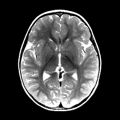

In [37]:
#Image of non-tumor
nonTumor=Image.open('BrainTumor_dataset/no/no0.jpg').resize((120,120))
nonTumor

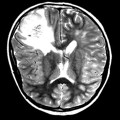

In [35]:
#Image of tumor
tumor=Image.open('BrainTumor_dataset/yes/y0.jpg').resize((120,120))
tumor


In [38]:
#set the directory 
yes=os.listdir('BrainTumor_dataset/yes')
no=os.listdir('BrainTumor_dataset/no')

#merge two data
data=np.concatenate([yes,no])

#map: yes to 1 and no to 0
x=np.full(len(yes), 1)
y=np.full(len(no), 0)
dataMapped= np.concatenate([x,y])
print(len(x), len(y))

1500 1500


In [40]:
#Data Augmentation (increase the amount of data by adding slightly modified copies of already existing data --> regularize and reduce overfitting)

def dataAugment(fileDir, numSample, saveDir):
    #ImageDataGenerator generates new images with some modifications
    dataGenerate =ImageDataGenerator(rotation_range=20, width_shift_range=0.3, height_shift_range=0.3, shear_range=0.2, brightness_range=(0.3,1.0), horizontal_flip=True, vertical_flip=True, fill_mode='reflect')
    for fileName in listdir(fileDir):
        image=cv2.imread(fileDir+'/'+fileName) #load an image from the specified file
        savePrefix= 'aug'+fileName[:-4]
        i=0
        for batch in dataGenerate.flow(x=image, batch_size=1, save_to_dir=saveDir, save_prefix=savePrefix,save_format='jpg'):
            i+=1
            if i> numSample:
                break

In [ ]:
#Data Preprocessing

X=[] #create an empty dataset of X

#Set height and width of the image
imgHeight=200
imgWidth=200
imageSize=[imgHeigh, imgWidth]

#Read images from the given directory:
for file in yes:
    img=cv2.imread('BrainTumor_dataset/yes'+file)
    imgResized= cv2.resize(img, (imgHeight, imgWidth))
    (b,g,r)=cv2.split(imgResized)
    img=cv2.merge([r,g,b])
    X.append(img)

for file in no:
    img=cv2.imread('BrainTumor_dataset/no'+file)
    imgResized= cv2.resize(img, (imgHeight, imgWidth))
    (b,g,r)=cv2.split(imgResized)
    img=cv2.merge([r,g,b])
    X.append(img)

X=np.squeeze(X) #remove single-dimensional entries from the shape of X
